# SNAX package tutorial - simulations

In [1]:
from snewpy.neutrino import Flavor
import os
from tqdm.notebook import tqdm
import numpy as np
from multimessenger.supernova import Supernova_Models as sn
from multimessenger.supernova.Plotter import Plotter
import plotly.express as px
import astropy.units as u
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [2]:
import straxen
straxen.print_versions(('strax', 'straxen', 'cutax', 'wfsim'))

*** Detector definition message ***
You are currently using the default XENON10 template detector.



,module,version,path,git
0,python,3.8.13,/opt/XENONnT/anaconda/envs/XENONnT_development...,None
1,strax,1.2.3,/opt/XENONnT/anaconda/envs/XENONnT_development...,None
2,straxen,1.8.3,/opt/XENONnT/anaconda/envs/XENONnT_development...,None
3,cutax,1.13.0,/dali/lgrandi/xenonnt/software/cutax/latest/cutax,None
4,wfsim,1.0.1,/home/melih/software/WFSim/wfsim,branch:master | d72c1b3


The `SNAX` is a wrapper around `snewpy` and it allows to compute CEvNS rates for all the snewpy models.

Each model contains variuous simulations with e.g. different EoS, or different progenitor properties. <br>
When only `model_name` is passed to `sn.Models()` it displays the existing files and asks you to select one. Otherwise, `filename` or `index` can be passed. <br>
Once the model is executed, and after every heavy computation the data is saved, and the next time it is directly fetched from the stored data. <br>
The output folder can be specified with the `storage` argument.

In [3]:
m = sn.Models("Nakazato_2013", index=7)

> You chose ~wisely~ ->	   [7]	nakazato-shen-z0.02-t_rev100ms-s20.0.fits
> Retrieving object self.storage/Nakazato_2013-nakazato-shen-z0_02-t_rev100ms-s20_0_fits.pickle


In [4]:
m

**Nakazato_2013 Model**: nakazato-shen-z0.02-t_rev100ms-s20.0.fits

|Parameter|Value|
|:--------|:----:|
|Progenitor mass | $20$ $\mathrm{M_{\odot}}$|
|EOS | SHEN |
|Metallicity | 0.02 |
|Revival time | $100$ $\mathrm{ms}$|
|composite | Xenon|
|duration | 20.05 s|
|distance | 10.0 kpc|
|volume | 5.9 t|
|executed | True|
|SN rate | 52 ct|

In [5]:
m.display_history

,date,version,user,history
0,2022/08/23 - 13:56 UTC,1.2.0,melih,Data Saved!
1,2022/08/23 - 13:57 UTC,1.2.0,melih,Fluxes computed!
2,2022/08/23 - 13:57 UTC,1.2.0,melih,Data Saved!
3,2022/08/23 - 13:57 UTC,1.2.0,melih,simulation Nakazato7_highstat is requested!
4,2022/08/23 - 13:57 UTC,1.2.0,melih,Data Saved!
5,2022/08/23 - 14:09 UTC,1.2.0,melih,simulation Nakazato7_highstat_st2 is requested!


In [6]:
m.compute_rates()

Computing for all isotopes:   0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

> Rates are computed at the source for 1 atom see rateper_Er/t attr (use scale_rates() for distance & volume)


These parts are better done in dali/midway. <br>


In [7]:
import nestpy
import pandas as pd
import straxen
downloader = straxen.MongoDownloader()
field_file="fieldmap_2D_B2d75n_C2d75n_G0d3p_A4d9p_T0d9n_PMTs1d3n_FSR0d65p_QPTFE_0d5n_0d4p.json.gz"
field_map = straxen.InterpolatingMap(
                    straxen.get_resource(downloader.download_single(field_file),
                                         fmt="json.gz"),
                    method="RegularGridInterpolator")

nc = nestpy.NESTcalc(nestpy.DetectorExample_XENON10())
## not sure if nestpy RNG issue was solved, so randomize NEST internal state
for i in range(np.random.randint(100)):
    nc.GetQuanta(nc.GetYields(energy=np.random.uniform(10,100)))

*** Detector definition message ***
You are currently using the default XENON10 template detector.



Caution, the times need to be passed in nanoseconds!

## Simulate ~high statistics t-shifted sample

In [8]:
N_events = 3000
sampled_Er = m.sample_data(N_events)
sampled_t = m.sample_data(N_events, dtype='time')

In [9]:
instr = m.generate_instructions(energy_deposition=sampled_Er, 
                                timemode="shifted", 
                                n_tot=N_events, nc=nc, fmap=field_map)
df = pd.DataFrame(instr)
print(f"Total duration {np.ptp(df['time'])*1e-9:.2f} seconds")
df

Total duration 1139.91 seconds


,event_number,type,time,x,y,z,amp,recoil,e_dep,g4id,vol_id,local_field,n_excitons,x_pri,y_pri,z_pri
0,1,1,452216995,28.342842,14.744443,-33.050415,7,7,1.021203,0,0,24.278802,0,0.0,0.0,0.0
1,1,2,452216995,28.342842,14.744443,-33.050415,66,7,1.021203,0,0,24.278802,0,0.0,0.0,0.0
2,2,1,91824124,-18.605976,-13.773094,-127.445541,1,7,0.567330,0,0,22.427369,0,0.0,0.0,0.0
3,2,2,91824124,-18.605976,-13.773094,-127.445541,42,7,0.567330,0,0,22.427369,0,0.0,0.0,0.0
4,3,2,3498966785,3.323450,63.778252,-14.284977,8,7,0.101818,0,0,25.011476,0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5252,2961,2,1123180845171,-4.888173,63.189308,-147.268448,72,7,1.182258,0,0,31.207002,1,0.0,0.0,0.0
5253,2962,1,1124196686761,49.391808,18.805367,-124.675117,7,7,0.963274,0,0,22.123442,0,0.0,0.0,0.0
5254,2962,2,1124196686761,49.391808,18.805367,-124.675117,63,7,0.963274,0,0,22.123442,0,0.0,0.0,0.0
5255,2963,2,1123434480206,13.895123,9.119431,-98.008675,2,7,0.029793,0,0,22.180078,0,0.0,0.0,0.0


In [10]:
st = m.simulate_one(df, "Nakazato7_highstat")

> Saved at <self.storage>/Nakazato_2013-nakazato-shen-z0_02-t_rev100ms-s20_0_fits.pickle!



Nakazato7_highstat already exists!
Nakazato7_highstat is fetched! Returning context!


In [11]:
m.display_simulation_history

context hash  \
versions                                           runid                                 
strax:1.2.3 straxen:1.8.3 cutax:1.13.0 wfsim:1.0.1 NaN                      rvchefp73l   
                                                   Nakazato7_highstat_st2   ibctvalxfl   
                                                   0                        rvchefp73l   

                                                                                             date  \
versions                                           runid                                            
strax:1.2.3 straxen:1.8.3 cutax:1.13.0 wfsim:1.0.1 NaN                     2022/08/23 - 13:57 UTC   
                                                   Nakazato7_highstat_st2  2022/08/23 - 14:09 UTC   
                                                   0                       2022/08/23 - 14:34 UTC   

                                                                            user  \
versions                                           runid                           
strax:1.2.3 straxen:1.8.3 cutax:1.13.0 wfsim:1.0.1 NaN                     melih   
                                                   Nakazato7_highstat_st2  melih   
                                                   0                       melih   

                                                                                                                       model  \
versions                                           runid                                                                       
strax:1.2.3 straxen:1.8.3 cutax:1.13.0 wfsim:1.0.1 NaN                     Nakazato_2013-nakazato-shen-z0_02-t_rev100ms-s...   
                                                   Nakazato7_highstat_st2  Nakazato_2013-nakazato-shen-z0_02-t_rev100ms-s...   
                                                   0                       Nakazato_2013-nakazato-shen-z0_02-t_rev100ms-s...   

                                                                          single SN events  \
versions                                           runid                                     
strax:1.2.3 straxen:1.8.3 cutax:1.13.0 wfsim:1.0.1 NaN                                  52   
                                                   Nakazato7_highstat_st2               52   
                                                   0                                    52   

                                                                           size  \
versions                                           runid                          
strax:1.2.3 straxen:1.8.3 cutax:1.13.0 wfsim:1.0.1 NaN                     5256   
                                                   Nakazato7_highstat_st2  5256   
                                                   0                       5257   

                                                                                        runid  
versions                                           runid                                       
strax:1.2.3 straxen:1.8.3 cutax:1.13.0 wfsim:1.0.1 NaN                                    NaN  
                                                   Nakazato7_highstat_st2                 NaN  
                                                   0                       Nakazato7_highstat

In [12]:
# rawrec = st.get_array("Nakazato7_highstat", "raw_records", time_range=(0,))

In [13]:
# rawrec

In [14]:
truth = st.get_df("Nakazato7_highstat", "truth")
np.min(truth['time'])*1e-9

Loading truth: |          | 0.00 % [00:00<?]

0.034592564

In [15]:
peak_basics = st.get_df("Nakazato7_highstat", "peak_basics")
peak_positions = st.get_df("Nakazato7_highstat", "peak_positions")

Loading peak_basics: |          | 0.00 % [00:00<?]

Loading peak_positions: |          | 0.00 % [00:00<?]

In [16]:
m.display_simulation_history

context hash  \
versions                                           runid                                 
strax:1.2.3 straxen:1.8.3 cutax:1.13.0 wfsim:1.0.1 NaN                      rvchefp73l   
                                                   Nakazato7_highstat_st2   ibctvalxfl   
                                                   0                        rvchefp73l   

                                                                                             date  \
versions                                           runid                                            
strax:1.2.3 straxen:1.8.3 cutax:1.13.0 wfsim:1.0.1 NaN                     2022/08/23 - 13:57 UTC   
                                                   Nakazato7_highstat_st2  2022/08/23 - 14:09 UTC   
                                                   0                       2022/08/23 - 14:34 UTC   

                                                                            user  \
versions                                           runid                           
strax:1.2.3 straxen:1.8.3 cutax:1.13.0 wfsim:1.0.1 NaN                     melih   
                                                   Nakazato7_highstat_st2  melih   
                                                   0                       melih   

                                                                                                                       model  \
versions                                           runid                                                                       
strax:1.2.3 straxen:1.8.3 cutax:1.13.0 wfsim:1.0.1 NaN                     Nakazato_2013-nakazato-shen-z0_02-t_rev100ms-s...   
                                                   Nakazato7_highstat_st2  Nakazato_2013-nakazato-shen-z0_02-t_rev100ms-s...   
                                                   0                       Nakazato_2013-nakazato-shen-z0_02-t_rev100ms-s...   

                                                                          single SN events  \
versions                                           runid                                     
strax:1.2.3 straxen:1.8.3 cutax:1.13.0 wfsim:1.0.1 NaN                                  52   
                                                   Nakazato7_highstat_st2               52   
                                                   0                                    52   

                                                                           size  \
versions                                           runid                          
strax:1.2.3 straxen:1.8.3 cutax:1.13.0 wfsim:1.0.1 NaN                     5256   
                                                   Nakazato7_highstat_st2  5256   
                                                   0                       5257   

                                                                                        runid  
versions                                           runid                                       
strax:1.2.3 straxen:1.8.3 cutax:1.13.0 wfsim:1.0.1 NaN                                    NaN  
                                                   Nakazato7_highstat_st2                 NaN  
                                                   0                       Nakazato7_highstat

In [17]:
peak_s1 = peak_basics[peak_basics['type'] == 1]
peak_s2 = peak_basics[peak_basics['type'] == 2]
peak_basics['type'].unique(), sum(peak_basics['type']==0), sum(peak_basics['type']==1), sum(peak_basics['type']==2)

(array([2, 1, 0], dtype=int8), 84, 1459, 2884)

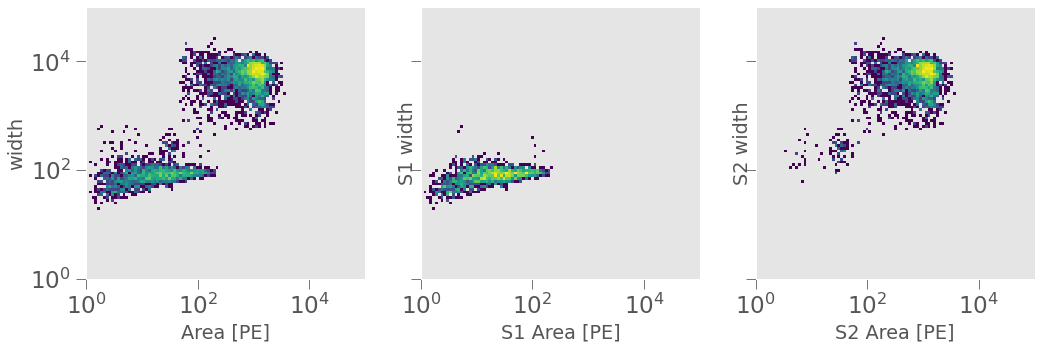

In [18]:
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(17,5), sharex=True, sharey=True)
ax0.grid(False); ax1.grid(False); ax2.grid(False)
ax0.hist2d(peak_basics["area"], peak_basics["range_50p_area"], 
           bins=(np.logspace(0,5,100),np.logspace(0,5,100)),
           norm=LogNorm());
ax0.set_xscale("log"); ax0.set_yscale("log")
ax0.set_xlabel("Area [PE]"); ax0.set_ylabel("width");


ax1.hist2d(peak_s1["area"], peak_s1["range_50p_area"], 
           bins=(np.logspace(0,5,100),np.logspace(0,5,100)),
           norm=LogNorm());
ax1.set_xscale("log"); ax1.set_yscale("log")
ax1.set_xlabel("S1 Area [PE]"); ax1.set_ylabel("S1 width");

ax2.hist2d(peak_s2["area"], peak_s2["range_50p_area"], 
           bins=(np.logspace(0,5,100),np.logspace(0,5,100)),
           norm=LogNorm());
ax2.set_xscale("log"); ax2.set_yscale("log")
ax2.set_xlabel("S2 Area [PE]"); ax2.set_ylabel("S2 width");

### Test different simulation configurations

In [19]:
import cutax, strax
st2 = cutax.contexts.xenonnt_sim_SR0v2_cmt_v8(cmt_run_id="026000", 
                                              output_folder=os.path.join(m.config['wfsim']['sim_folder'], "strax_data"))
# set s1 minimum coincidence to 0
st2.set_config({"s1_min_coincidence":0})

In [20]:
st2 = m.simulate_one(df, "Nakazato7_highstat_st2", context=st2)

> Saved at <self.storage>/Nakazato_2013-nakazato-shen-z0_02-t_rev100ms-s20_0_fits.pickle!



Nakazato7_highstat_st2 already exists!
Nakazato7_highstat_st2 is fetched! Returning context!


In [21]:
m.display_simulation_history

context hash  \
versions                                           runid                                 
strax:1.2.3 straxen:1.8.3 cutax:1.13.0 wfsim:1.0.1 NaN                      rvchefp73l   
                                                   Nakazato7_highstat_st2   ibctvalxfl   
                                                   0                        rvchefp73l   
                                                   0                        ibctvalxfl   

                                                                                             date  \
versions                                           runid                                            
strax:1.2.3 straxen:1.8.3 cutax:1.13.0 wfsim:1.0.1 NaN                     2022/08/23 - 13:57 UTC   
                                                   Nakazato7_highstat_st2  2022/08/23 - 14:09 UTC   
                                                   0                       2022/08/23 - 14:34 UTC   
                                                   0                       2022/08/23 - 14:34 UTC   

                                                                            user  \
versions                                           runid                           
strax:1.2.3 straxen:1.8.3 cutax:1.13.0 wfsim:1.0.1 NaN                     melih   
                                                   Nakazato7_highstat_st2  melih   
                                                   0                       melih   
                                                   0                       melih   

                                                                                                                       model  \
versions                                           runid                                                                       
strax:1.2.3 straxen:1.8.3 cutax:1.13.0 wfsim:1.0.1 NaN                     Nakazato_2013-nakazato-shen-z0_02-t_rev100ms-s...   
                                                   Nakazato7_highstat_st2  Nakazato_2013-nakazato-shen-z0_02-t_rev100ms-s...   
                                                   0                       Nakazato_2013-nakazato-shen-z0_02-t_rev100ms-s...   
                                                   0                       Nakazato_2013-nakazato-shen-z0_02-t_rev100ms-s...   

                                                                          single SN events  \
versions                                           runid                                     
strax:1.2.3 straxen:1.8.3 cutax:1.13.0 wfsim:1.0.1 NaN                                  52   
                                                   Nakazato7_highstat_st2               52   
                                                   0                                    52   
                                                   0                                    52   

                                                                           size  \
versions                                           runid                          
strax:1.2.3 straxen:1.8.3 cutax:1.13.0 wfsim:1.0.1 NaN                     5256   
                                                   Nakazato7_highstat_st2  5256   
                                                   0                       5257   
                                                   0                       5257   

                                                                                            runid  
versions                                           runid                                           
strax:1.2.3 straxen:1.8.3 cutax:1.13.0 wfsim:1.0.1 NaN                                        NaN  
                                                   Nakazato7_highstat_st2                     NaN  
                                                   0                           Nakazato7_highstat  
                                                   0                       Nakazato7_hig

In [22]:
peak_basics2 = st2.get_df("Nakazato7_highstat_st2", "peak_basics")

Loading peak_basics: |          | 0.00 % [00:00<?]

In [23]:
peak_s12 = peak_basics2[peak_basics2['type'] == 1]
peak_s22 = peak_basics2[peak_basics2['type'] == 2]
peak_basics2['type'].unique(), sum(peak_basics2['type']==0), sum(peak_basics2['type']==1), sum(peak_basics2['type']==2)

(array([2, 1, 0], dtype=int8), 27, 1594, 2866)

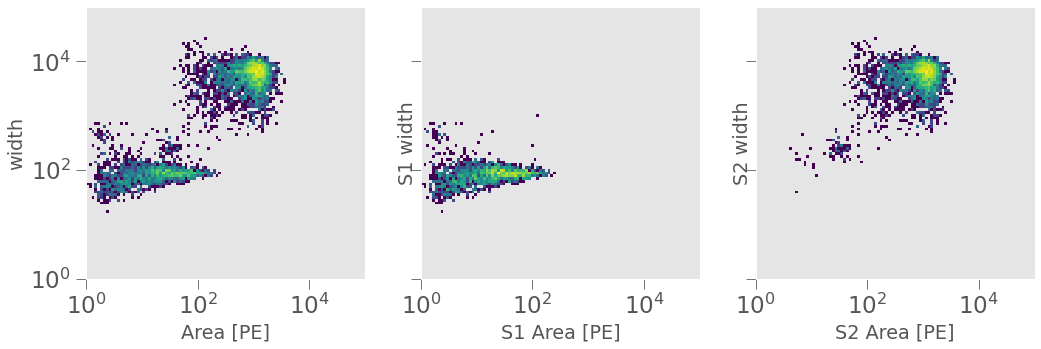

In [24]:
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(17,5), sharex=True, sharey=True)
ax0.grid(False); ax1.grid(False); ax2.grid(False)
ax0.hist2d(peak_basics2["area"], peak_basics2["range_50p_area"], 
           bins=(np.logspace(0,5,100),np.logspace(0,5,100)),
           norm=LogNorm());
ax0.set_xscale("log"); ax0.set_yscale("log")
ax0.set_xlabel("Area [PE]"); ax0.set_ylabel("width");


ax1.hist2d(peak_s12["area"], peak_s12["range_50p_area"], 
           bins=(np.logspace(0,5,100),np.logspace(0,5,100)),
           norm=LogNorm());
ax1.set_xscale("log"); ax1.set_yscale("log")
ax1.set_xlabel("S1 Area [PE]"); ax1.set_ylabel("S1 width");

ax2.hist2d(peak_s22["area"], peak_s22["range_50p_area"], 
           bins=(np.logspace(0,5,100),np.logspace(0,5,100)),
           norm=LogNorm());
ax2.set_xscale("log"); ax2.set_yscale("log")
ax2.set_xlabel("S2 Area [PE]"); ax2.set_ylabel("S2 width");

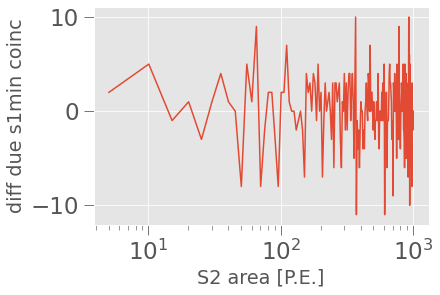

In [29]:
len(peak_s22), len(peak_s2)
bins = np.linspace(0, 1000, 200)
a = np.histogram(peak_s2['area'], bins=bins)[0]
b = np.histogram(peak_s22['area'], bins=bins)[0]
plt.semilogx(bins[1:], a-b)
plt.xlabel("S2 area [P.E.]");
plt.ylabel("diff due s1min coinc");

### Test the plugin

In [26]:
from sn_rate_plugin import SNPugins
st.register(SNPugins)

sn_rate_plugin.SNPugins

Loading sn_rate: |          | 0.00 % [00:00<?]

4427


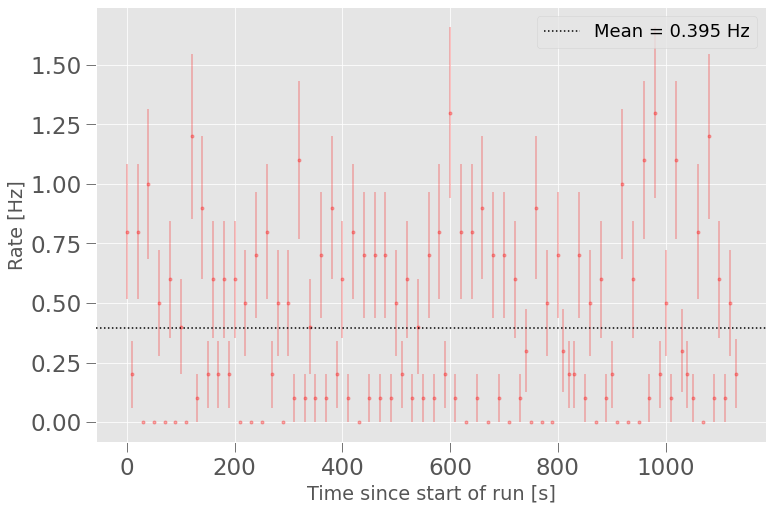

In [27]:
st.set_config({"sn_time_bin":10})
df_rate = st.get_df("Nakazato7_highstat", 'sn_rate')
plt.figure(figsize=(12,8))
plt.errorbar(x=(df_rate['time']-df_rate['time'][0])/1e9, 
             y=df_rate['sn_rate'],
             yerr=df_rate['sn_rate_err'], 
             color='r', marker='.',linestyle='',alpha=0.3)
plt.axhline(np.mean(df_rate['sn_rate']), color='k',linestyle=':', 
            zorder=10, label='Mean = %.3f Hz'%np.mean(df_rate['sn_rate']))

plt.legend()
plt.xlabel('Time since start of run [s]')
plt.ylabel('Rate [Hz]')
plt.show()

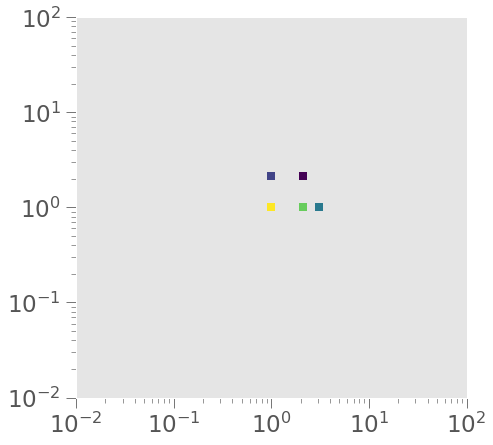

In [37]:
bins = np.linspace(0, 1000, 2000)
a = np.histogram(peak_s2['area'], bins=bins)[0]
b = np.histogram(peak_s22['area'], bins=bins)[0]

c = np.histogram(peak_s2['range_50p_area'], bins=bins)[0]
d = np.histogram(peak_s22['range_50p_area'], bins=bins)[0]


fig, ax0 = plt.subplots(figsize=(7,7))
ax0.grid(False); 
ax0.hist2d(a-b, c-d, 
           bins=(np.logspace(-2,2,50),np.logspace(-2,2,50)), norm=LogNorm());
ax0.set_xscale("log"); ax0.set_yscale("log")